In [65]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 10,6

In [66]:
%store -r prod_reduced

In [67]:
prod_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 0 to 36135
Data columns (total 12 columns):
calendar_day                      14820 non-null datetime64[ns]
production_process                14820 non-null category
production_process_description    14820 non-null category
strategy                          14820 non-null category
work_center                       13450 non-null category
wc_description                    14820 non-null category
block                             14815 non-null object
shape                             14795 non-null category
size                              14795 non-null object
sku                               14820 non-null object
material_description              14820 non-null object
ton                               14820 non-null int64
dtypes: category(6), datetime64[ns](1), int64(1), object(4)
memory usage: 897.4+ KB


In [68]:
justton=prod_reduced[['calendar_day','ton']]
justton=justton[justton['ton'] > 1]
print(justton.count())
inddf=justton.set_index('calendar_day')

calendar_day    12485
ton             12485
dtype: int64


In [69]:
grouper=inddf.resample('M').sum()

In [70]:
print(grouper.count())
print(grouper.tail())


ton    83
dtype: int64
                ton
calendar_day       
2019-08-31     8221
2019-09-30    37758
2019-10-31    45647
2019-11-30    42609
2019-12-31    17141


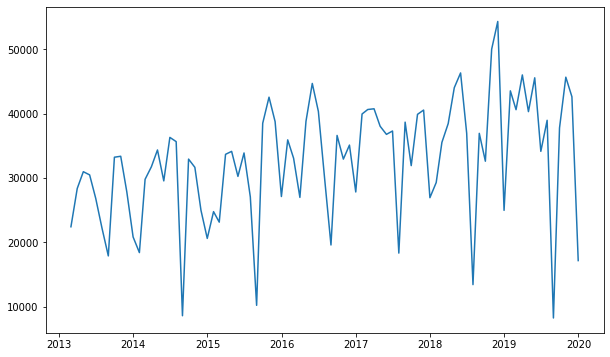

In [71]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.plot(grouper)

In [72]:
#to check if the data is stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    #dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

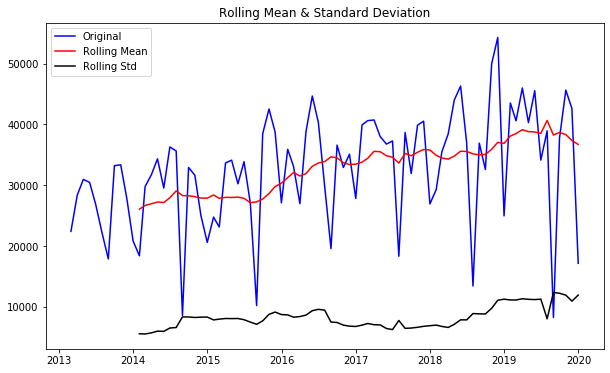

Results of Dickey-Fuller Test:
Test Statistic                 -1.595557
p-value                         0.485825
#Lags Used                     11.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [73]:
test_stationarity(grouper)

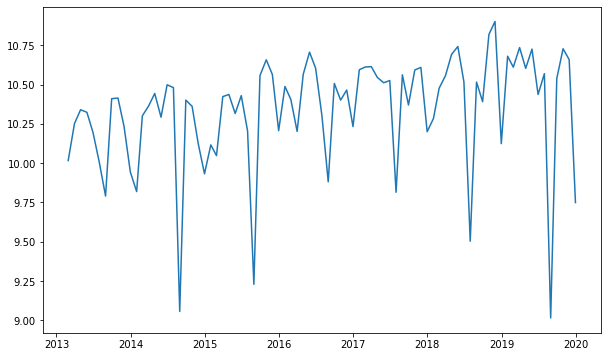

In [74]:
df_log = np.log(grouper)
plt.plot(df_log)

# differencing

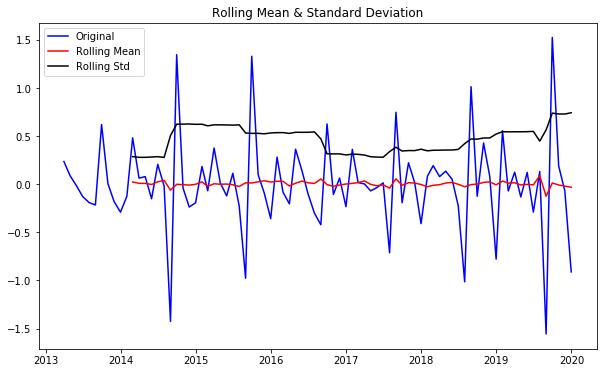

Results of Dickey-Fuller Test:
Test Statistic                 -5.582206
p-value                         0.000001
#Lags Used                     11.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [75]:
ts_diff = df_log - df_log.shift()
ts_diff.dropna(inplace = True)

test_stationarity(ts_diff)

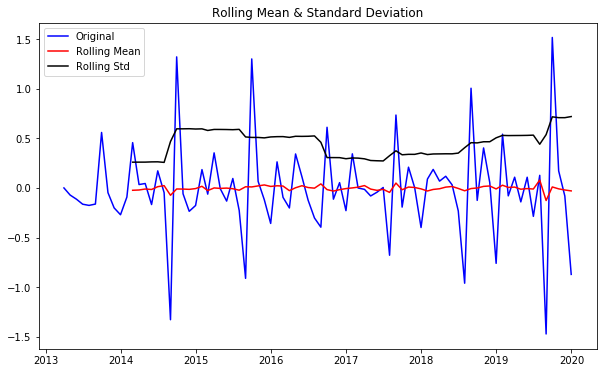

Results of Dickey-Fuller Test:
Test Statistic                -5.845583e+00
p-value                        3.690322e-07
#Lags Used                     1.100000e+01
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64


In [76]:
ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
ts_diff_exp.dropna(inplace = True)
test_stationarity(ts_diff_exp)

Decomposing

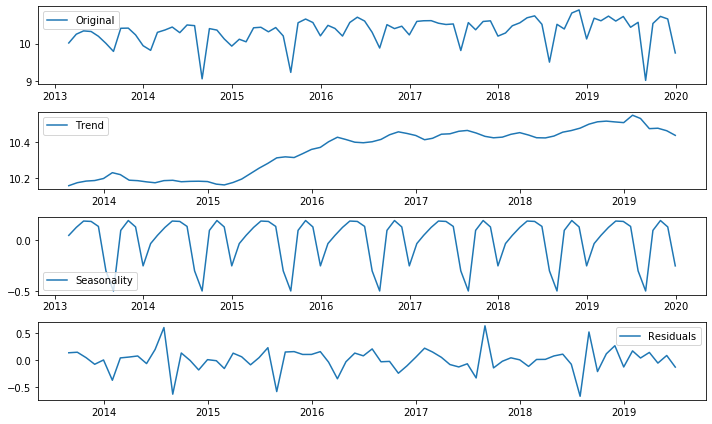

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [78]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [79]:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

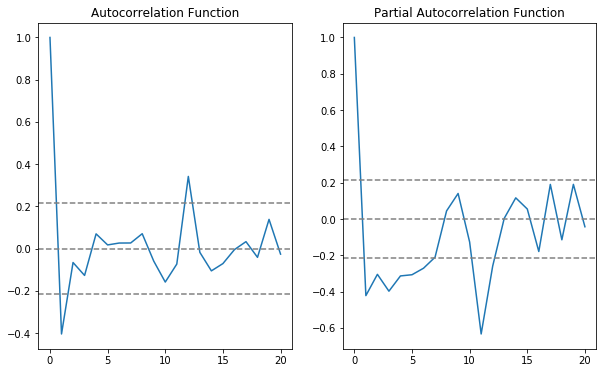

In [80]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

In [81]:
from statsmodels.tsa.arima_model import ARIMA

Text(0.5, 1.0, 'RSS: 14.8197')

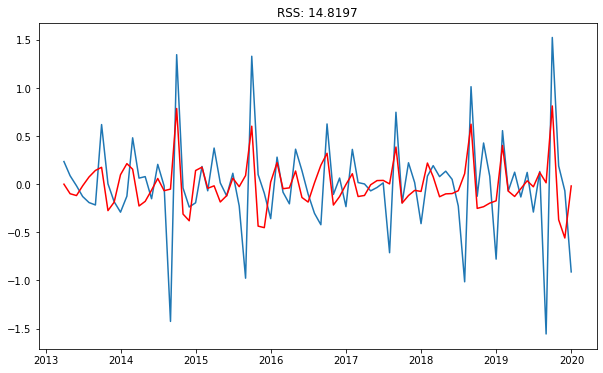

In [82]:
#AR model
model = ARIMA(df_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff['ton'])**2))

Text(0.5, 1.0, 'RSS: 10.1944')

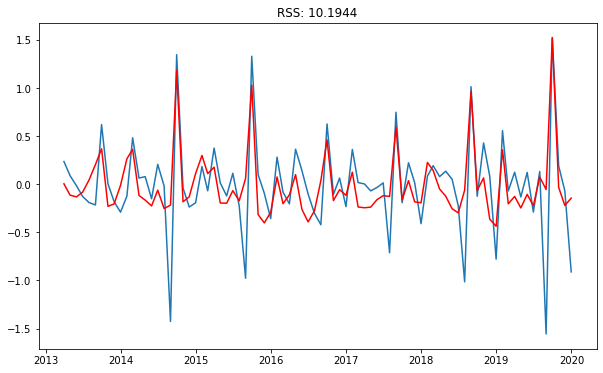

In [83]:
# MA model

model = ARIMA(df_log, order=(0, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff['ton'])**2))

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'RSS: 9.6172')

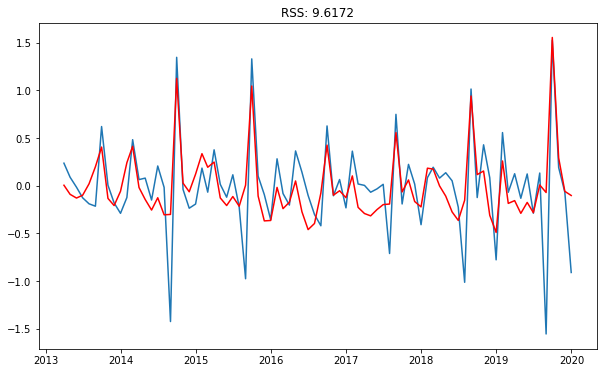

In [84]:
# ARIMA model

model = ARIMA(df_log, order=(2, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff['ton'])**2))

In [86]:
preds = pd.Series(results_AR.fittedvalues, copy = True)
preds_cumsum = preds.cumsum()
print (preds_cumsum.head())

calendar_day
2013-03-31    0.004384
2013-04-30   -0.086753
2013-05-31   -0.216764
2013-06-30   -0.316974
2013-07-31   -0.298053
Freq: M, dtype: float64


In [90]:
preds_log = pd.Series(df_log.ix[0], index=df_log.index)
preds_log = preds_log.add(preds_cumsum,fill_value=0)
preds_log.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


calendar_day
2013-02-28         NaN
2013-03-31    0.004384
2013-04-30   -0.086753
2013-05-31   -0.216764
2013-06-30   -0.316974
Freq: M, dtype: float64

In [100]:
preds_ARIMA = np.exp(preds_log)
preds_ARIMA.head()
#plt.plot(grouper)
#plt.plot(preds_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum((preds_ARIMA-grouper['ton'])**2)/len(grouper['ton'])))

calendar_day
2013-02-28         NaN
2013-03-31    1.004393
2013-04-30    0.916904
2013-05-31    0.805120
2013-06-30    0.728349
Freq: M, dtype: float64